# Elo Merchant Category Recommendation - Binary outlier detector
End date: _2019. february 19._<br/>

This tutorial notebook is part of a series for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. LynxKite does not yet support some of the data preprocessing, thus they need to be done in Python. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In [1]:
import gc
import time
import warnings
import datetime
import calendar
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from datetime import date
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import matplotlib.gridspec as gridspec
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.model_selection import StratifiedKFold, KFold

%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)
gc.enable()

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Input data preparation
### Transactions

In [3]:
df_new_trans = pd.read_csv("preprocessed/trans_merch_new_agg.csv")
df_new_trans = reduce_mem_usage(df_new_trans)

df_hist_trans = pd.read_csv("preprocessed/trans_merch_hist_agg.csv")
df_hist_trans = reduce_mem_usage(df_hist_trans)

Starting memory usage: 289.84 MB
Reduced memory usage: 70.52 MB (75.7% reduction)
Starting memory usage: 325.36 MB
Reduced memory usage: 96.86 MB (70.2% reduction)


In [4]:
df_hist_trans.drop(['Unnamed: 0'], inplace=True, axis=1)
df_new_trans.drop(['Unnamed: 0'], inplace=True, axis=1)

### Train and test data

In [5]:
df_train = pd.read_csv("preprocessed/train_parsed_outlier_marked.csv", index_col="card_id")
df_test = pd.read_csv("preprocessed/test_parsed.csv", index_col="card_id")

### LynxKite export

In [6]:
df_lk_train = pd.read_csv("LynxKite_export/LynxKite_outlier_viral_modeling_train.csv", index_col="card_id")
df_lk_test = pd.read_csv("LynxKite_export/LynxKite_outlier_viral_modeling_test.csv", index_col="card_id")

In [7]:
df_lk_train.drop(['new_id', 'outlier', 'target', 'type'], inplace=True, axis=1)
df_lk_test.drop(['new_id', 'outlier', 'target', 'type'], inplace=True, axis=1)

### Merging

In [8]:
df_train = pd.merge(df_train, df_lk_train, on='card_id', how='left')
df_test = pd.merge(df_test, df_lk_test, on='card_id', how='left')

In [9]:
df_train = pd.merge(df_train, df_hist_trans, on='card_id', how='left')
df_test = pd.merge(df_test, df_hist_trans, on='card_id', how='left')

df_train = pd.merge(df_train, df_new_trans, on='card_id', how='left')
df_test = pd.merge(df_test, df_new_trans, on='card_id', how='left')

In [10]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Starting memory usage: 212.97 MB
Reduced memory usage: 127.67 MB (40.1% reduction)
Starting memory usage: 128.51 MB
Reduced memory usage: 81.70 MB (36.4% reduction)


## Outlier selection
### Remove correlating features
[Drop Highly Correlated Features](https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/)

In [11]:
columns2drop = ['card_id', 'first_active_month', 'viral_outlier_test', 'viral_outlier_train', 'viral_roles',
                'hist_avg_purchases_lag3_sum', 'hist_avg_purchases_lag3_mean', 'hist_avg_purchases_lag6_sum',
                'hist_avg_purchases_lag6_mean', 'hist_avg_purchases_lag12_sum', 'hist_avg_purchases_lag12_mean',
                'viral_outlier_spread_over_iterations', 'hist_transactions_count', 'hist_purchase_year_min',
                'new_transactions_count', 'new_authorized_flag_mean']

features_train = [c for c in df_train.columns if c not in columns2drop]
columns2drop.remove('card_id')
features_test = [c for c in df_test.columns if c not in columns2drop]

df_train_outlier = df_train[features_train]
df_train_target = df_train[features_train]
df_test_clean = df_test[features_test]

In [12]:
df_train_outlier.shape[1], df_train_target.shape[1], df_test_clean.shape[1]

(276, 276, 275)

In [13]:
corr_matrix = df_train_outlier.corr().abs()

In [14]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [15]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
len(to_drop)

123

In [16]:
df_train_target = df_train_target.drop(to_drop, axis=1)
df_train_outlier = df_train_outlier.drop(to_drop, axis=1)
df_test_clean = df_test_clean.drop(to_drop, axis=1)

In [17]:
print('There are {:} features in the original training set, {:} features in the non-correlating training for target set.'.format(df_train.shape[1], df_train_target.shape[1]))
print('There are {:} features in the original test set, {:} features in the non-correlating test set.'.format(df_test.shape[1], df_test_clean.shape[1]))

There are 292 features in the original training set, 153 features in the non-correlating training for target set.
There are 290 features in the original test set, 152 features in the non-correlating test set.


### Marking the outliers

In [18]:
df_train_target.loc[:, 'outlier'] = np.where(df_train_target['target']<-30, 1, 0)
df_train_outlier.loc[:, 'outlier'] = np.where(df_train_outlier['target']<-30, 1, 0)

In [19]:
print('There are {:,} marked outliers in the training set.'.format(len(df_train_outlier[df_train_outlier['outlier'] == 1]['outlier'])))

There are 2,207 marked outliers in the training set.


## Training
[LightGBM parameters](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst)<br/>
[Combining your model with a model without outlier](https://www.kaggle.com/waitingli/combining-your-model-with-a-model-without-outlier)<br/>
[Comparison between LGB boosting methods (goss, gbdt and dart)](https://www.kaggle.com/c/home-credit-default-risk/discussion/60921)
### Target prediction without outliers

In [20]:
df_train_target.shape[1], df_train_outlier.shape[1], df_test_clean.shape[1]

(153, 153, 152)

In [21]:
features_train = list(df_train_target.columns)
features_test = list(df_test_clean.columns)
features_test.remove('card_id')

In [22]:
df_train_target.drop(df_train_target[df_train_target['outlier'] == 1].index, inplace=True, axis=0)

In [23]:
features_train.remove('target')
features_train.remove('outlier')

In [24]:
target = df_train_target['target']
df_train_target = df_train_target.drop(['target', 'outlier'], axis=1)

In [25]:
df_train_target.shape, target.shape, df_test_clean.shape

((199710, 151), (199710,), (123623, 152))

In [26]:
len(features_train), len(features_test)

(151, 151)

In [27]:
param = {
    'num_leaves': 31,
    'min_data_in_leaf': 25, 
    'objective': 'regression',
    'max_depth': 7,
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "feature_fraction": 0.85,
    "bagging_freq": 8,
    "bagging_fraction": 0.9,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.13,
    "random_state": 2333,
    "verbosity": -1
}

folds = KFold(n_splits=5, shuffle=True, random_state=2333)

oof = np.zeros(len(df_train_target))
predictions = np.zeros(len(df_test_clean))

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train_target.values, target.values)):
    print("\nFold {}.".format(fold_ + 1))
    trn_data = lgb.Dataset(df_train_target.iloc[trn_idx], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train_target.iloc[val_idx], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=200)
    oof[val_idx] = clf.predict(df_train_target.iloc[val_idx], num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features_train
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict(df_test[features_test], num_iteration=clf.best_iteration) / folds.n_splits


Fold 1.
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.60927	valid_1's rmse: 1.62089
[200]	training's rmse: 1.5792	valid_1's rmse: 1.5949
[300]	training's rmse: 1.5646	valid_1's rmse: 1.58428
[400]	training's rmse: 1.55494	valid_1's rmse: 1.57867
[500]	training's rmse: 1.54736	valid_1's rmse: 1.575
[600]	training's rmse: 1.54112	valid_1's rmse: 1.57257
[700]	training's rmse: 1.53571	valid_1's rmse: 1.5711
[800]	training's rmse: 1.53085	valid_1's rmse: 1.57027
[900]	training's rmse: 1.52624	valid_1's rmse: 1.56955
[1000]	training's rmse: 1.52212	valid_1's rmse: 1.56915
[1100]	training's rmse: 1.51812	valid_1's rmse: 1.56888
[1200]	training's rmse: 1.51422	valid_1's rmse: 1.56852
[1300]	training's rmse: 1.51038	valid_1's rmse: 1.5683
[1400]	training's rmse: 1.50677	valid_1's rmse: 1.56816
[1500]	training's rmse: 1.50325	valid_1's rmse: 1.5681
[1600]	training's rmse: 1.4999	valid_1's rmse: 1.56795
[1700]	training's rmse: 1.49651	valid_1's rmse: 1.

In [28]:
cross_validation_lgb = np.sqrt(mean_squared_error(target, oof))
print('Cross-validation score: ' + str(cross_validation_lgb))

Cross-validation score: 1.5612106111990063


In [29]:
clf.save_model('models/lightgbm_wo_outliers_with_features_from_lk.txt')

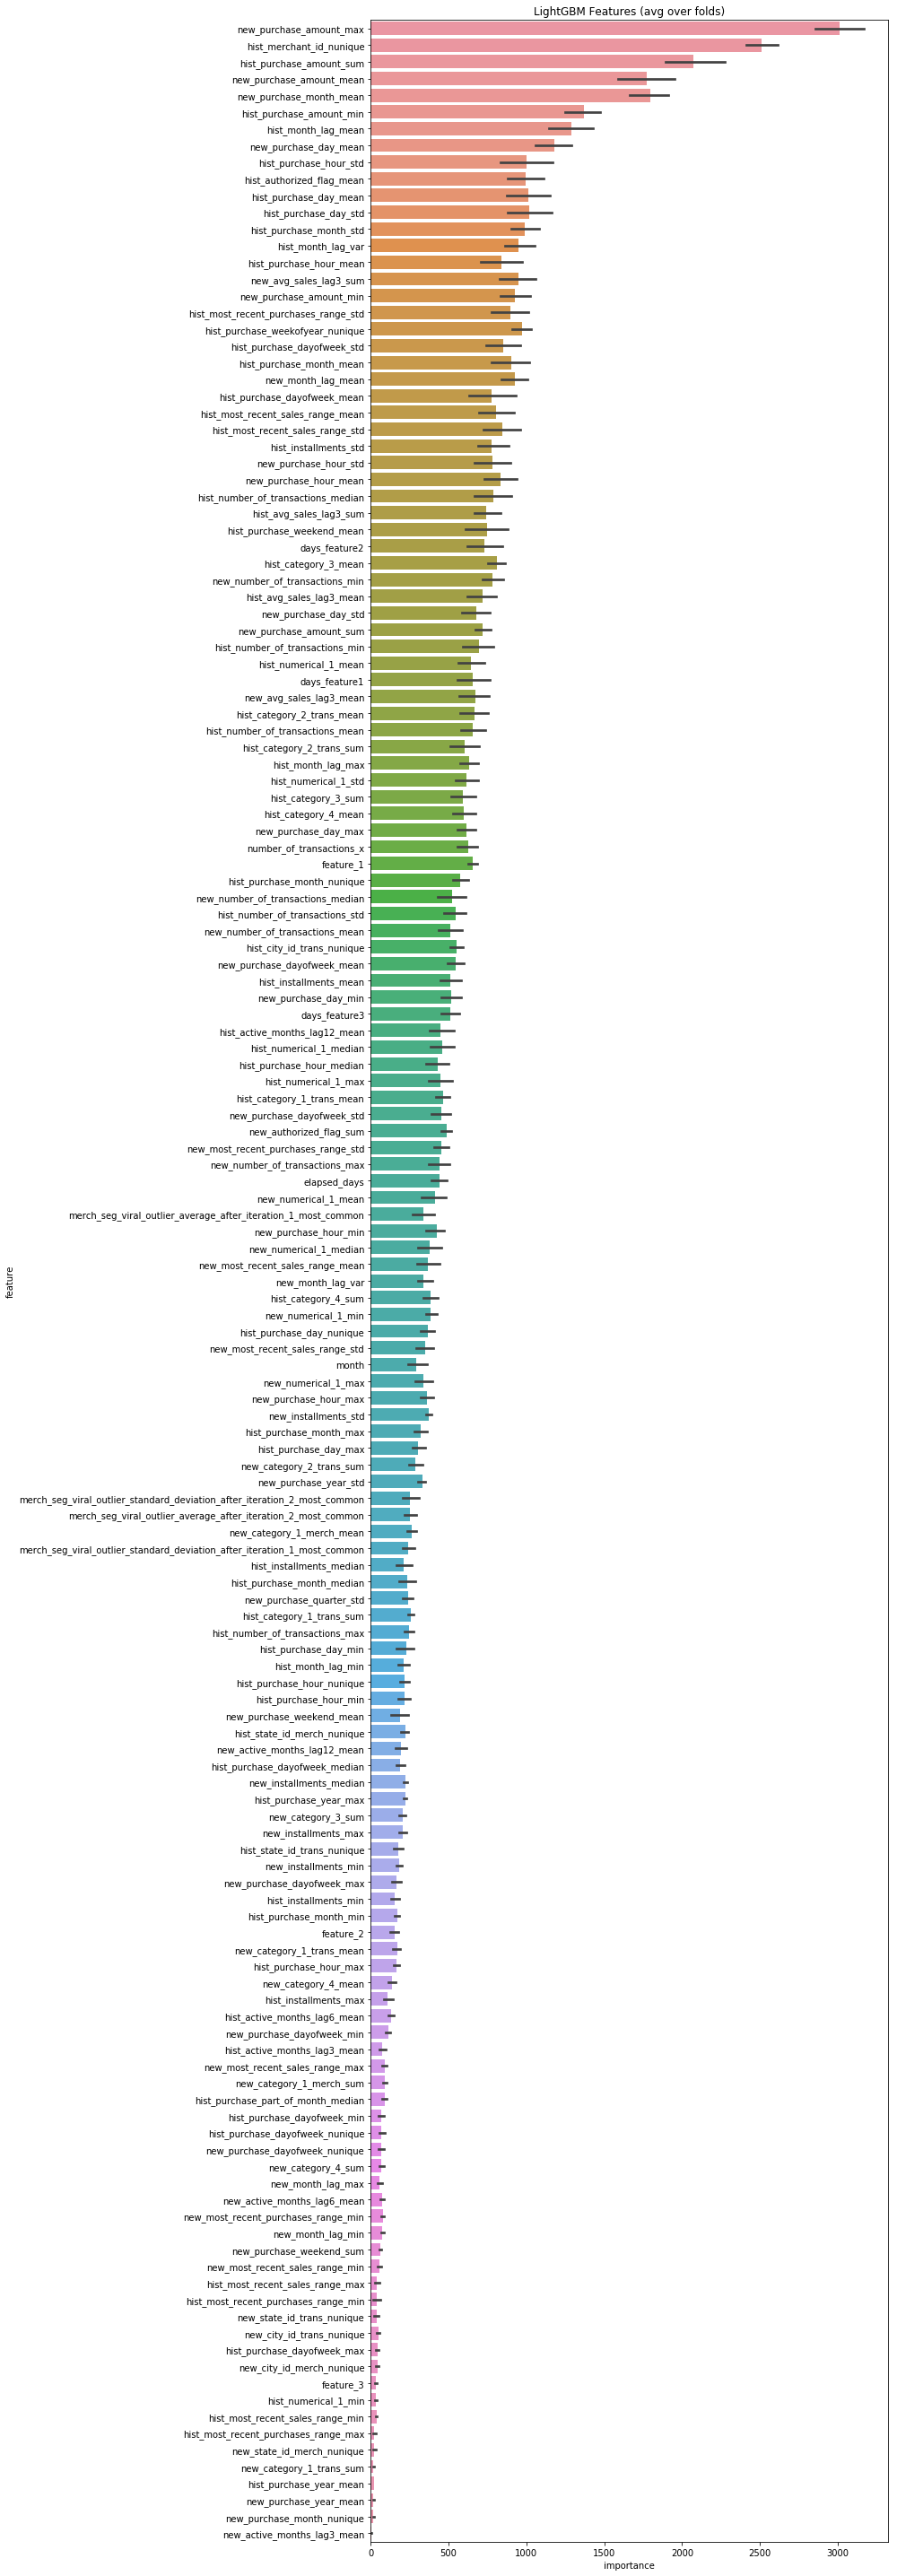

In [30]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df['feature'].isin(cols)]

plt.figure(figsize=(14, 40))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [31]:
df_sub = pd.DataFrame({"card_id":df_test["card_id"].values})
df_sub["target"] = predictions
df_sub.to_csv("output/lgbm_wo_outliers_{}.csv".format(cross_validation_lgb), index=False)
print("`output/lgbm_wo_outliers_{}.csv` was saved".format(cross_validation_lgb))

### Outlier classification
Removing outliers

In [32]:
target = df_train_outlier['outlier']
df_train_outlier = df_train_outlier.drop(['target', 'outlier'], axis=1)

In [33]:
param = {
    'num_leaves': 31,
    'min_data_in_leaf': 30, 
    'objective': 'binary',
    'max_depth': 6,
    'learning_rate': 0.01,
    "boosting": "rf",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9,
    "bagging_seed": 11,
    "metric": 'binary_logloss',
    "lambda_l1": 0.1,
    "random_state": 2333,
    "verbosity": -1
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2333)

oof = np.zeros(len(df_train_outlier))
predictions = np.zeros(len(df_test_clean))

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train_outlier.values, target.values)):
    print("\nFold {}.".format(fold_ + 1))
    trn_data = lgb.Dataset(df_train_outlier.iloc[trn_idx], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train_outlier.iloc[val_idx], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=200)
    oof[val_idx] = clf.predict(df_train_outlier.iloc[val_idx], num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features_train
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict(df_test[features_test], num_iteration=clf.best_iteration) / folds.n_splits


Fold 1.
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0323286	valid_1's binary_logloss: 0.0324396
[200]	training's binary_logloss: 0.0322981	valid_1's binary_logloss: 0.0323889
[300]	training's binary_logloss: 0.0322859	valid_1's binary_logloss: 0.0323957
Early stopping, best iteration is:
[127]	training's binary_logloss: 0.0322903	valid_1's binary_logloss: 0.0323683

Fold 2.
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0319611	valid_1's binary_logloss: 0.0346174
[200]	training's binary_logloss: 0.0319492	valid_1's binary_logloss: 0.0346033
[300]	training's binary_logloss: 0.0319345	valid_1's binary_logloss: 0.0345945
Early stopping, best iteration is:
[122]	training's binary_logloss: 0.0319278	valid_1's binary_logloss: 0.0345746

Fold 3.
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0320909	valid_1's binary_logloss: 0.0340884
[20

In [36]:
cross_validation_o = log_loss(target, oof)
print('Cross-validation score: ' + str(cross_validation_o))

Cross-validation score: 0.033469338231857125


In [37]:
clf.save_model('models/lightgbm_outliers_detector_with_features_from_lk.txt')

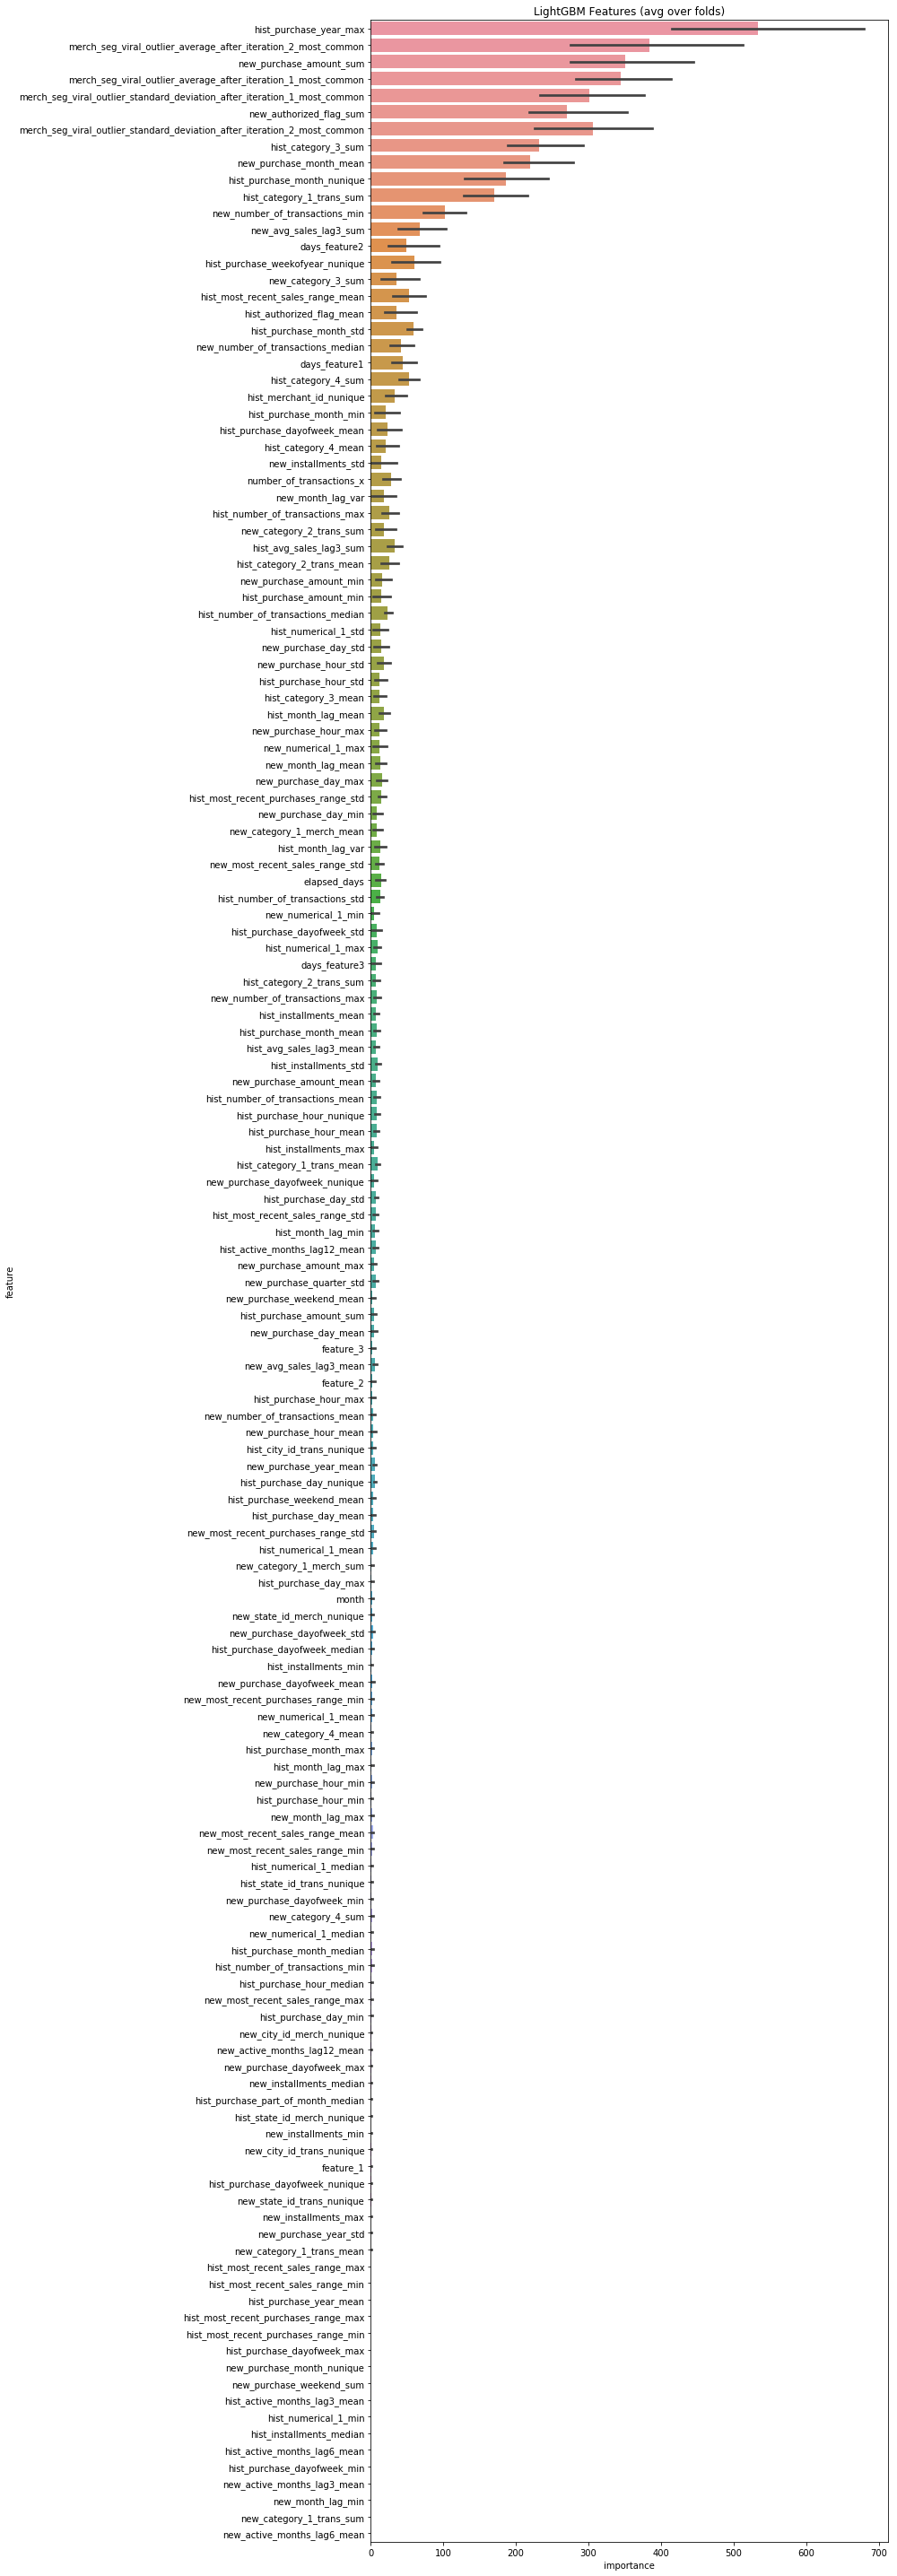

In [38]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df['feature'].isin(cols)]

plt.figure(figsize=(14, 40))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [39]:
df_sub = pd.DataFrame({"card_id":df_test["card_id"].values})
df_sub["target"] = predictions
df_sub.to_csv("output/lgbm_outliers_detector_{}.csv".format(cross_validation_o), index=False)
print("`output/lgbm_outliers_detector_{}.csv` was saved".format(cross_validation_o))

`output/lgbm_outliers_detector_0.033469338231857125.csv` was saved


In [48]:
df_outlier_prob = pd.DataFrame({
    "card_id": df_test["card_id"].values
})
df_outlier_prob["target"] = predictions

## Combining submission
Let's suppose that we have the same percentage of outliers in the test set as in the training set.

In [47]:
len(df_train[df_train['target'] < -30])/len(df_train)*len(df_test)

0.010930233709890698

In [50]:
outlier_id = pd.DataFrame(df_outlier_prob.sort_values(by='target', ascending = False).head(25000)['card_id'])

In [ ]:
df_outlier_prob = pd.DataFrame({
    "card_id": df_test["card_id"].values
})
df_outlier_prob["is_outlier"] = predictions

Loading the predictions of LightGBM without outliers.

In [54]:
model_without_outliers = pd.read_csv("output/lgbm_wo_outliers_1.5614365898340974.csv")
model_without_outliers = reduce_mem_usage(model_without_outliers)

Starting memory usage:  1.89 MB
Reduced memory usage:  1.18 MB (37.5% reduction)


In [55]:
best_submission = pd.read_csv('output/lgbm_3.671395629792665.csv')

In [56]:
most_likely_liers = df_lgbmwo.merge(outlier_id, how='right')
most_likely_liers[:5]

,card_id,target
0,C_ID_0ab67a22ab,-0.335938
1,C_ID_f7cada36d3,0.920898
2,C_ID_7f1041e8e1,-0.143066
3,C_ID_a7f2d6984e,0.368652
4,C_ID_22e4a47c72,1.563477


In [57]:
%%time
for card_id in most_likely_liers['card_id']:
    model_without_outliers.loc[model_without_outliers['card_id'] == card_id,
    'target'] = most_likely_liers.loc[most_likely_liers['card_id'] == card_id, 'target'].values

CPU times: user 7min 5s, sys: 391 ms, total: 7min 6s
Wall time: 7min 9s


In [58]:
model_without_outliers.to_csv("output/combined_submission.csv", index=False)

* Random Forest (LB score: 5.994)
* Logistic Regression (LB score: 5.990)
* Random Forest & AdaBoost (LB score: 5.986)